In [6]:
#!/usr/bin/env python3

import sys

sys.path.append("..")

from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt  # type: ignore
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.transforms as transforms


import datetime as dt
import numpy as np
import pandas as pd


import mgs
import pathogens
import stats
from populations import us_population

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

In [21]:
target_pathogens = ["sars_cov_2", "influenza", "norovirus"]

predictor_counts = defaultdict(int)

norovirus_added_days = dt.timedelta(days=15.5)
influenza_added_days = dt.timedelta(days=3.5)

pathogen_predictors = [] 
for pathogen_name in target_pathogens:

    for predictor in pathogens.pathogens[pathogen_name].estimate_incidences():
        
        

        if pathogen_name == "norovirus":
            date = predictor.get_dates()[0] + norovirus_added_days

        elif pathogen_name == "influenza":
            date = predictor.get_dates()[0] +influenza_added_days
            
        elif pathogen_name == "sars_cov_2":
            date = predictor.get_dates()[0]

        location = *predictor.get_location(), # country, state, county
        incidence = predictor.get_data()

        if date < dt.date(2020, 5, 15) or date > dt.date(2022, 1, 15):
            continue
        

        if pathogen_name in ["norovirus", "influenza"]:
            predictor_counts[(pathogen_name, date, location)] += 1

        pathogen_predictors.append(
            (
                pathogen_name,
                date,
                *location,
                incidence,
            )
        )
    for key, count in predictor_counts.items():
        if count != 2:
            print(f"The following pathogen has {count} occurences")

df = pd.DataFrame(
    pathogen_predictors,
    columns=["pathogen","date","country", "state", "county", "incidence"],
)

# Norovirus and Influenza have subtypes that we want to aggregate on, hence we are summing estimates with the same pathogen, date and location.
df = df.groupby(['pathogen', 'country', 'state', 'county', 'date'], as_index=False,dropna=False).agg({'incidence': 'sum'})

#sort by date
df = df.sort_values(by=['date']).fillna("")






In [22]:
def get_averaged_incidence(df, pathogen_name):
    averaged_incidence = []

    
    for date, group in df[df["pathogen"] == pathogen_name].groupby("date"):
        weights = group.apply(
            lambda row: us_population(
                row["date"].year,
                row["county"],
                row["state"],
            ).people,
            axis=1,
        )

        incidence = np.average(group["incidence"], weights=weights)
        averaged_incidence.append((date, incidence))

    return pd.DataFrame(
        averaged_incidence, columns=["date", f"{pathogen_name}"]
    )

In [23]:
df_averaged_incidences = (
    get_averaged_incidence(df, "sars_cov_2")
    .merge(
        get_averaged_incidence(df, "influenza"),
        on="date",
        how="outer",
    )
    .merge(
        # select only two colums from df
        df[df["pathogen"] == "norovirus"][["date", "incidence"]].rename(
            columns={"incidence": "norovirus"}
        ),
        on="date",
        how="outer",
    )
)   

In [24]:
print(df_averaged_incidences)

           date    sars_cov_2  influenza  norovirus
0    2020-05-15    172.405552        NaN        NaN
1    2020-05-16    175.513066        NaN   1.348624
2    2020-05-17    176.566460        NaN        NaN
3    2020-05-18    183.571533        NaN        NaN
4    2020-05-19    185.941670        NaN        NaN
..          ...           ...        ...        ...
606  2022-01-11   9774.165964        NaN        NaN
607  2022-01-12  10083.688536   30.36834        NaN
608  2022-01-13  10050.901646        NaN        NaN
609  2022-01-14   9768.307324        NaN        NaN
610  2022-01-15   8545.857997        NaN        NaN

[611 rows x 4 columns]


In [25]:
mgs_data = mgs.MGSData.from_repo()
sample_dates = {
    "rothman": [],
    "crits_christoph": [],
    "spurbeck" : [],
}
for study, bioproject in sorted(mgs.target_bioprojects.items()):
    if study in ["brinch"]:
        continue
    # print(study)
    viral_samples = mgs_data.sample_attributes(
        *bioproject,
        enrichment=mgs.Enrichment.VIRAL,
    )
    sum = 0
    for sample, sample_attributes in viral_samples.items():
        # print(sample_attributes.date)
        sample_dates[study].append(sample_attributes.date)
        



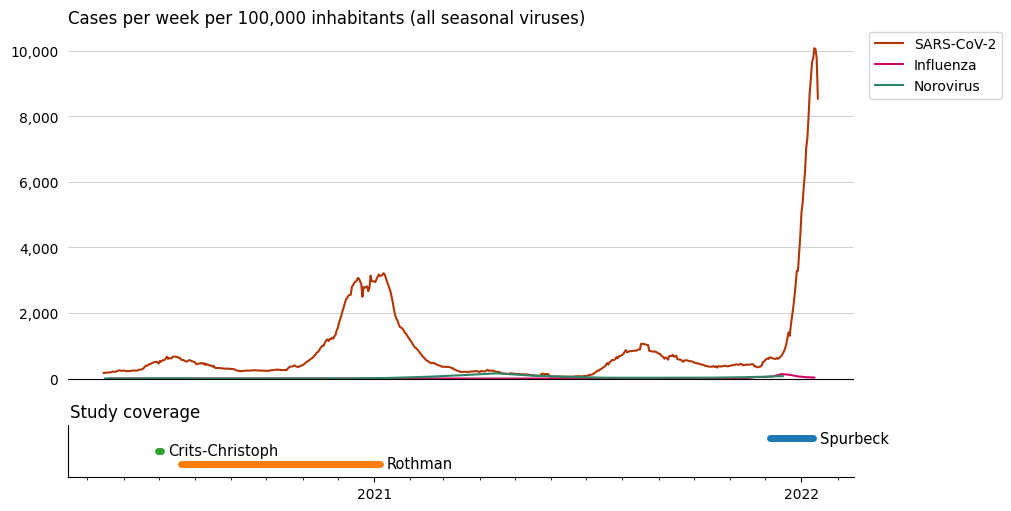

<Figure size 640x480 with 0 Axes>

In [26]:
fig, axs = plt.subplots(
    2,
    1,
    constrained_layout=True,
    sharex=True,
    gridspec_kw={"height_ratios": [7, 1]},
    figsize=(10, 5),
)

virus_plot_colors = {
    "sars_cov_2": "#b13607",
    "influenza": "#cf0a66",
    "norovirus": "#2c8565",
}

study_coverage_colors = {
    "crits_christoph": "#2ca02c",
    "rothman": "#ff7f0e",
    "spurbeck": "#1f77b4",
}

axs[0].plot(
    df_averaged_incidences["date"],
    df_averaged_incidences["sars_cov_2"],
    label="SARS-CoV-2",
    color=virus_plot_colors["sars_cov_2"],
)




axs[0].plot(
    df_averaged_incidences.dropna(subset=["influenza"]).sort_values(by="date")[
        "date"
    ],
    df_averaged_incidences.dropna(subset=["influenza"]).sort_values(by="date")[
        "influenza"
    ],
    label="Influenza",
    color=virus_plot_colors["influenza"],
)

axs[0].plot(
    df_averaged_incidences.dropna(subset=["norovirus"]).sort_values(by="date")[
        "date"
    ],
    df_averaged_incidences.dropna(subset=["norovirus"]).sort_values(by="date")[
        "norovirus"
    ],
    label="Norovirus",
    color=virus_plot_colors["norovirus"],
)


study_coverage_y_values = range(1, len(sample_dates) + 1)


def transform_study_name(s):
    return "-".join([word.capitalize() for word in s.split("_")])


for index, (study, dates) in zip(
    study_coverage_y_values, sample_dates.items()
):
    axs[1].plot(
        [
            min(dates),
            max(dates) + dt.timedelta(days=2),
        ],  # hacky, have to add two days so Crits-Cristoph shows up in the study coverage plot
        [index, index],
        color=study_coverage_colors[study],
        # alpha = 0.4,
        linewidth=5,
        solid_capstyle="round",
    )

    x_offset = dt.timedelta(days=8)
    axs[1].text(
        max(dates) + x_offset,
        index,
        transform_study_name(study),
        fontsize=10.5,
        va="center",
        # color=study_coverage_colors[study],
    )


axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["left"].set_visible(False)

axs[0].xaxis.set_visible(True)
axs[0].xaxis.set_ticks_position("none")
axs[0].axhline(0, color="black", linewidth=0.8)

axs[0].yaxis.set_ticks_position("none")
axs[0].legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)


axs[0].set_title("Cases per week per 100,000 inhabitants (all seasonal viruses)", loc="left")

axs[1].text( #title
        dt.datetime(2020, 4, 16
                    ),
        5,
        "Study coverage",
        fontsize=12,
        va="center",
)

axs[0].yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, p: format(int(x), ","))
)

axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[1].set_ylim(0, max(study_coverage_y_values) + 1)
axs[1].set_yticks([])
axs[1].set_yticklabels([])

for y_loc in range(2000, 10001, 2000):
    axs[0].axhline(y_loc, color="gray", linestyle="-", lw=0.5, alpha=0.5)


axs[1].xaxis.set_major_locator(mdates.YearLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))


axs[1].xaxis.set_minor_locator(mdates.MonthLocator())
axs[1].xaxis.set_minor_formatter("")

plt.savefig("figures/all_incidences.png", dpi=300, bbox_inches="tight")
plt.show()
plt.clf()

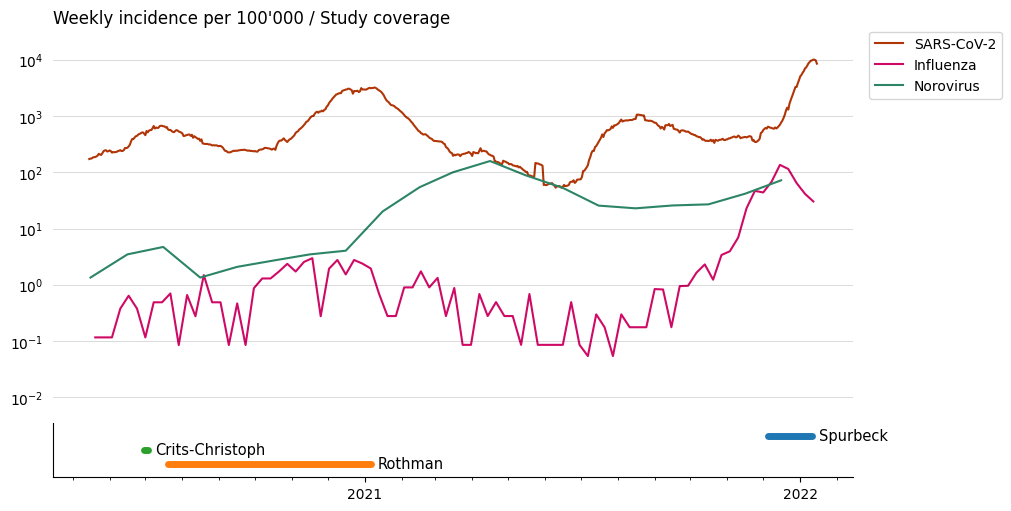

<Figure size 640x480 with 0 Axes>

2020-07-20 2021-01-04
2020-06-30 2020-07-01
2021-12-05 2022-01-09


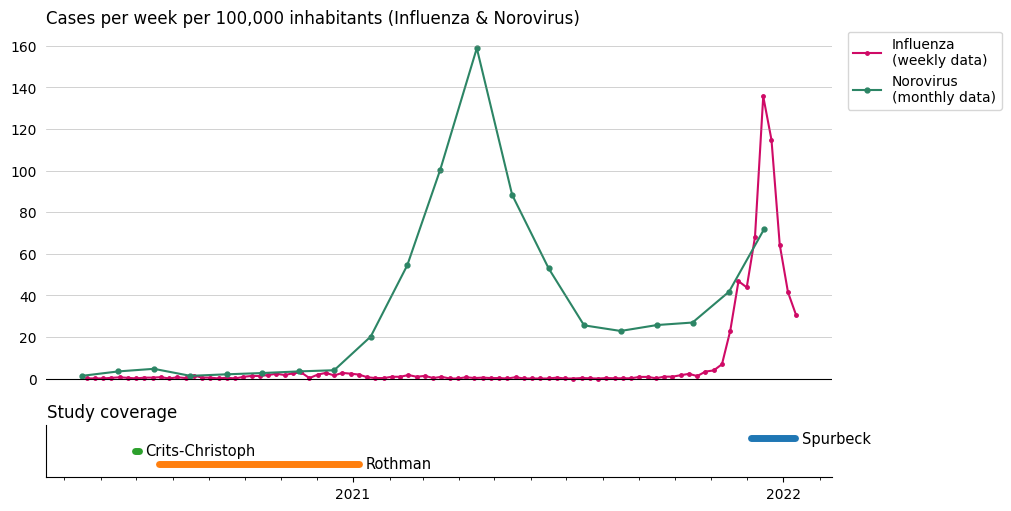

<Figure size 640x480 with 0 Axes>

In [27]:
fig, axs = plt.subplots(
    2,
    1,
    constrained_layout=True,
    sharex=True,
    gridspec_kw={"height_ratios": [7, 1]},
    figsize=(10, 5),
)

axs[0].plot(
    df_averaged_incidences.dropna(subset=["influenza"]).sort_values(by="date")[
        "date"
    ],
    df_averaged_incidences.dropna(subset=["influenza"]).sort_values(by="date")[
        "influenza"
    ],

    marker="o",
    markersize=2.5,
    label="Influenza\n(weekly data)",
    color=virus_plot_colors["influenza"],
)
axs[0].plot(
    df_averaged_incidences.dropna(subset=["norovirus"]).sort_values(by="date")[
        "date"
    ],
    df_averaged_incidences.dropna(subset=["norovirus"]).sort_values(by="date")[
        "norovirus"
    ],
    marker="o",
    markersize=3.5,
    label="Norovirus\n(monthly data)",
    color=virus_plot_colors["norovirus"],
)

study_coverage_y_values = range(1, len(sample_dates) + 1)



for index, (study, dates) in zip(
    study_coverage_y_values, sample_dates.items()
):
    print(min(dates), max(dates))
    axs[1].plot(
        [
            min(dates),
            max(dates) + dt.timedelta(days=2),
        ],  # hacky, have to add two days so Crits-Cristoph shows up in the study coverage plot
        [index, index],
        color=study_coverage_colors[study],
        # alpha=0.2,
        linewidth=5,
        solid_capstyle="round",
    )

    x_offset = dt.timedelta(days=8)
    axs[1].text(
        max(dates) + x_offset,
        index,
        transform_study_name(study),
        fontsize=10.5,
        va="center",
        # color=study_coverage_colors[study],
    )

axs[0].spines["right"].set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["left"].set_visible(False)

axs[0].xaxis.set_visible(True)
axs[0].xaxis.set_ticks_position("none")
axs[0].axhline(0, color="black", linewidth=0.8)
# remove ticks on axs[0] y axis, but still show labels on y axis
axs[0].yaxis.set_ticks_position("none")

axs[0].set_title("Cases per week per 100,000 inhabitants (Influenza & Norovirus)", loc="left")

axs[0].legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

axs[1].text( #title
        dt.datetime(2020, 4, 16
                    ),
        5,
        "Study coverage",
        fontsize=12,
        va="center",
)


axs[1].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[1].set_ylim(0, max(study_coverage_y_values) + 1)
axs[1].set_yticks([])
axs[1].set_yticklabels([])

for y_loc in range(20, 161, 20):
    axs[0].axhline(y_loc, color="gray", linestyle="-", lw=0.5, alpha=0.5)


axs[1].xaxis.set_major_locator(mdates.YearLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axs[1].xaxis.set_minor_locator(mdates.MonthLocator())
axs[1].xaxis.set_minor_formatter("")
plt.savefig("figures/w_o_covid_incidences.png", dpi=300, bbox_inches="tight")

plt.show()
plt.clf()

In [ ]:
# fig, axs = plt.subplots(
#     2,
#     1,
#     constrained_layout=True,
#     sharex=True,
#     gridspec_kw={"height_ratios": [7, 1]},
#     figsize=(10, 5),
# )


# virus_plot_colors = {
#     "sars_cov_2": "#b13607",
#     "influenza": "#cf0a66",
#     "norovirus": "#2c8565",
# }

# study_coverage_colors = {
#     "crits_christoph": "#2ca02c",
#     "rothman": "#ff7f0e",
#     "spurbeck": "#1f77b4",
# }

# axs[0].plot(
#     df_averaged_incidences["date"],
#     df_averaged_incidences["sars_cov_2"],
#     label="SARS-CoV-2",
#     color=virus_plot_colors["sars_cov_2"],
# )


# axs[0].plot(
#     df_averaged_incidences.dropna(subset=["influenza"]).sort_values(by="date")[
#         "date"
#     ],
#     df_averaged_incidences.dropna(subset=["influenza"]).sort_values(by="date")[
#         "influenza"
#     ],
#     label="Influenza",
#     color=virus_plot_colors["influenza"],
# )

# axs[0].plot(
#     df_averaged_incidences.dropna(subset=["norovirus"]).sort_values(by="date")[
#         "date"
#     ],
#     df_averaged_incidences.dropna(subset=["norovirus"]).sort_values(by="date")[
#         "norovirus"
#     ],
#     label="Norovirus",
#     color=virus_plot_colors["norovirus"],
# )


# study_coverage_y_values = range(1, len(sample_dates) + 1)


# def transform_study_name(s):
#     return "-".join([word.capitalize() for word in s.split("_")])


# for index, (study, dates) in zip(
#     study_coverage_y_values, sample_dates.items()
# ):
#     axs[1].plot(
#         [
#             min(dates),
#             max(dates) + dt.timedelta(days=2),
#         ],  # hacky, have to add two days so Crits-Cristoph shows up in the study coverage plot
#         [index, index],
#         color=study_coverage_colors[study],
#         # alpha = 0.4,
#         linewidth=5,
#         solid_capstyle="round",
#     )

#     x_offset = dt.timedelta(days=8)
#     axs[1].text(
#         max(dates) + x_offset,
#         index,
#         transform_study_name(study),
#         fontsize=10.5,
#         va="center",
#         # color=study_coverage_colors[study],
#     )


# axs[0].spines["right"].set_visible(False)
# axs[0].spines["top"].set_visible(False)
# axs[0].spines["bottom"].set_visible(False)
# axs[0].spines["left"].set_visible(False)

# axs[0].xaxis.set_visible(True)
# axs[0].xaxis.set_ticks_position("none")
# axs[0].axhline(0, color="black", linewidth=0.8)

# axs[0].yaxis.set_ticks_position("none")
# axs[0].set_title("Weekly incidence per 100'000 / Study coverage", loc="left")
# axs[0].set_yscale("log")
# axs[0].set_ylim(10 ** -2.3, 10 ** 4.5)


# for i in range(-2, 5):
#     axs[0].axhline(10**i, color="black", linewidth=0.5, alpha=0.2)


# axs[0].legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)


# axs[1].spines["right"].set_visible(False)
# axs[1].spines["top"].set_visible(False)
# axs[1].set_ylim(0, max(study_coverage_y_values) + 1)
# axs[1].set_yticks([])
# axs[1].set_yticklabels([])


# # set logarithmic horizontal lines


# axs[1].xaxis.set_major_locator(mdates.YearLocator())
# axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))


# axs[1].xaxis.set_minor_locator(mdates.MonthLocator())
# axs[1].xaxis.set_minor_formatter("")

# plt.savefig("figures/all_incidences_logged.png", dpi=300, bbox_inches="tight")
# plt.show()
# plt.clf()